In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from time import clock
import matplotlib.pyplot as plt

In [2]:
class_data = pd.read_csv("winequality-red.csv", delimiter=";")
X, y = class_data.iloc[:,:-1], class_data.iloc[:,-1]-3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [3]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', xgb.XGBClassifier(num_class=6,objective='multi:softmax'))
])

gbm_param_grid = {
    'clf__learning_rate': np.arange(0.01, 0.2, 0.01),
    'clf__max_depth': range(5, 12, 1),
    'clf__n_estimators': range(75, 125, 5),
    'clf__gamma': np.arange(0, 0.2, 0.01),
    'clf__reg_alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'clf__subsample': np.arange(0.4, 1, 0.05),
    'clf__colsample_bytree': np.arange(0.4, 1, 0.1)
}

# Perform RandomizedSearchCV
randomized = RandomizedSearchCV(pipeline, param_distributions=gbm_param_grid, n_iter=400, cv=4, scoring='accuracy',
                                refit=True, n_jobs = -1, verbose=1, random_state=123)

# Fit the estimator
start = clock()
randomized.fit(X_train, y_train)
stop = clock()
print('Time to hypertune: {:.3f}'.format(stop-start))

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  4.1min finished


Time to hypertune: 250.196


In [4]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', randomized.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(randomized.best_score_))

# Extract best model from 'grid'
best_model = randomized.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test, y_test)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc))

# Print CV confusion matrix
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(randomized.cv_results_['mean_fit_time'][randomized.best_index_]))
print('Mean score time: {:.4f}'.format(randomized.cv_results_['mean_score_time'][randomized.best_index_]))

Best hyperparameters:
 {'clf__subsample': 0.8499999999999999, 'clf__reg_alpha': 1e-07, 'clf__n_estimators': 105, 'clf__max_depth': 10, 'clf__learning_rate': 0.060000000000000005, 'clf__gamma': 0.01, 'clf__colsample_bytree': 0.8999999999999999}
Best CV accuracy: 0.693
Test set accuracy of best model: 0.659
[[ 0  0  1  0  0  0]
 [ 0  0  8  5  0  0]
 [ 0  2 96 31  2  0]
 [ 0  1 28 94  8  0]
 [ 0  0  1 17 21  0]
 [ 0  0  0  3  2  0]]
Mean fit time: 1.3539
Mean score time: 0.0210


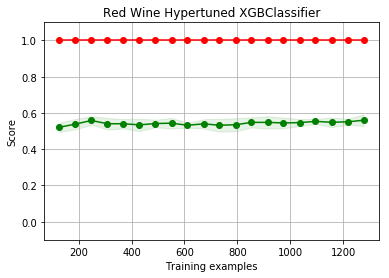

In [5]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, n_jobs=-1, 
                                                        cv=5, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Hypertuned XGBClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()